<a href="https://colab.research.google.com/github/leanring-machine/yt-classifier/blob/main/notebooks/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Preprocess

In [1]:
from google.colab import drive
import os
import zipfile

drive_content = '/content/drive/MyDrive/yt-classifier/'
data_path = './thumbnail'

In [4]:
drive.mount('/content/drive')

zip_ref = zipfile.ZipFile(drive_content + 'data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


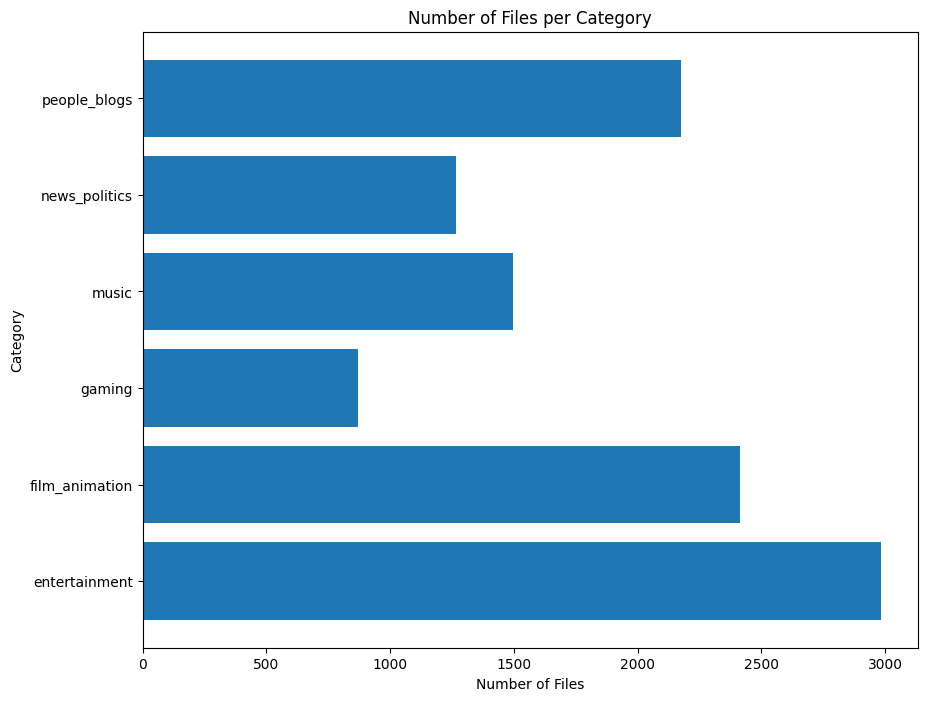

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

category_df = pd.read_csv('video_category.csv')
category_info = category_df.set_index('name')['id'].to_dict()


selected_category = [
    'entertainment', 'film_animation', 'gaming',
    'music', 'news_politics', 'people_blogs'
]

category_counts = {}
total_counts = 0

for c in selected_category:
  dir = os.path.join(data_path, c)
  category_counts[c] = len(os.listdir(dir))
  total_counts += category_counts[c]

plt.figure(figsize=(10, 8))
plt.barh(list(category_counts.keys()), list(category_counts.values()))
plt.xlabel('Number of Files')
plt.ylabel('Category')
plt.title('Number of Files per Category')
plt.show()

In [6]:
import numpy as np

category_index = {v:k for k,v in category_info.items()}
ctoi = [-1] * 30
now = 0
for i in sorted(list(category_index.keys())):
  if category_index[i] in selected_category:
    ctoi[i] = now
    now = now + 1

In [7]:
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


flat_data_arr=[] #input array
target_arr=[] #output array

x=[]
y=np.array([])

#path which contains all the categories of images
for c in selected_category:
    print(f'loading... category : {c}')
    path = os.path.join(data_path, c)
    size = 0
    for img in os.listdir(path):
      i = imread(os.path.join(path,img))
      if i.shape == (180, 320, 3):
        x += [i]
        size += 1
    y = np.append(y, np.array([ctoi[category_info[c]]] * size))
    print(f'loaded category:{c} successfully')

loading... category : entertainment
loaded category:entertainment successfully
loading... category : film_animation
loaded category:film_animation successfully
loading... category : gaming
loaded category:gaming successfully
loading... category : music
loaded category:music successfully
loading... category : news_politics
loaded category:news_politics successfully
loading... category : people_blogs
loaded category:people_blogs successfully


In [8]:
# flat_data=np.array(flat_data_arr)
x=np.stack(x)
y=y.reshape(-1,1)
# flat_data *= 255

In [9]:
x.shape

(11207, 180, 320, 3)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.7, random_state=12353
)

In [11]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.4 MB/s eta 0:00:00


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

num_classes = len(selected_category)
input_shape = (180, 320, 3)

learning_rate = 0.0005
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 128  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 128 X 128
Patch size: 8 X 8
Patches per image: 256
Elements per patch: 192


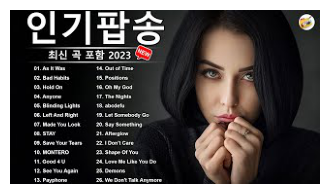

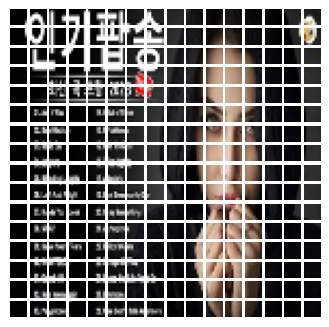

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [17]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [18]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [21]:
class_weight = {}
for idx, category_idx in enumerate(ctoi):
  if category_idx != -1:
    class_weight[category_idx] = (1 / category_counts[category_index[idx]]) * (total_counts / 2.0)
print(class_weight)


{0: 2.3202898550724638, 1: 3.7456550802139037, 2: 6.440804597701149, 3: 2.5739549839228295, 4: 1.8791079812206573, 5: 4.422651933701657}


In [22]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
        class_weight=class_weight
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
28/28 [==============================] - 22s 245ms/step - loss: 9.1277 - accuracy: 0.2060 - val_loss: 1.7044 - val_accuracy: 0.2624
Epoch 2/100
28/28 [==============================] - 5s 197ms/step - loss: 5.7555 - accuracy: 0.2448 - val_loss: 1.6307 - val_accuracy: 0.3096
Epoch 3/100
28/28 [==============================] - 7s 260ms/step - loss: 5.3402 - accuracy: 0.2651 - val_loss: 1.6433 - val_accuracy: 0.3248
Epoch 4/100
28/28 [==============================] - 5s 195ms/step - loss: 5.0994 - accuracy: 0.2835 - val_loss: 1.6180 - val_accuracy: 0.3478
Epoch 5/100
28/28 [==============================] - 5s 196ms/step - loss: 4.9963 - accuracy: 0.2949 - val_loss: 1.6125 - val_accuracy: 0.3643
Epoch 6/100
28/28 [==============================] - 4s 151ms/step - loss: 4.8137 - accuracy: 0.3158 - val_loss: 1.5976 - val_accuracy: 0.3261
Epoch 7/100
28/28 [==============================] - 5s 195ms/step - loss: 4.7273 - accuracy: 0.3301 - val_loss: 1.5242 - val_accuracy: 0.400

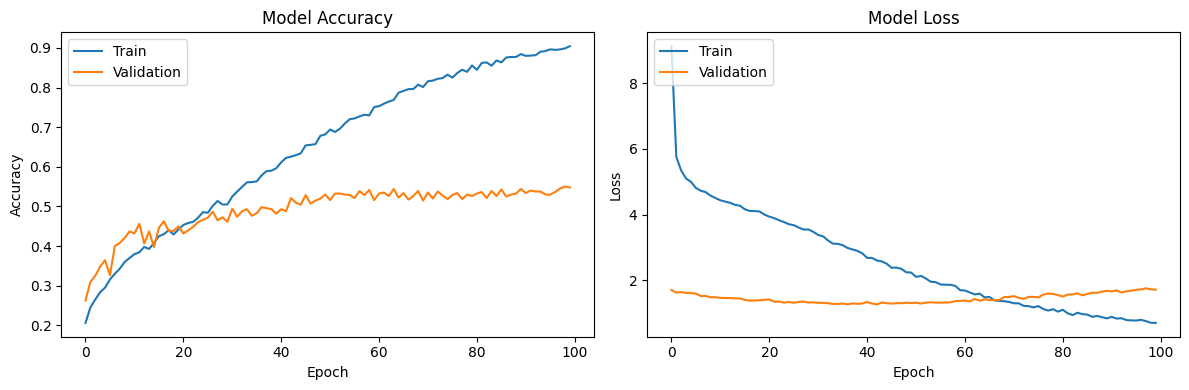

In [23]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
def plot_training_history(history):
    # 정확도 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 손실 함수 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# 학습 과정 시각화
plot_training_history(history)

In [24]:
vit_classifier.save('/content/drive/MyDrive/yt-classifier/vit_model.h5')

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import joblib


load_model = keras.models.load_model(
    '/content/drive/MyDrive/yt-classifier/vit_model.h5',
    custom_objects={
        'Patches': Patches,
        'PatchEncoder': PatchEncoder
    }
)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 예측 결과 시각화 및 분석
def predict_image(model, image_path, class_names):
    img_path = image_path
    img = imread(img_path)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    print(prediction)
    predicted_label = np.argmax(prediction)
    print(predicted_label)
    confidence = prediction[0][predicted_label]

    plt.imshow(img)
    plt.axis('off') # 
    plt.title(f"Predicted: {class_names[predicted_label]}")
    plt.show()

In [ ]:
# 이미지 예측
image_path = '/content/thumbnail/gaming/6Q199tLsOXM.jpg'
predict_image(load_model, image_path, selected_category)

1/1 [==============================] - 1s 1s/step
[[ 1.3792454   1.440691   -5.7563725   4.2492995   0.01355521 -0.7397678 ]]
3


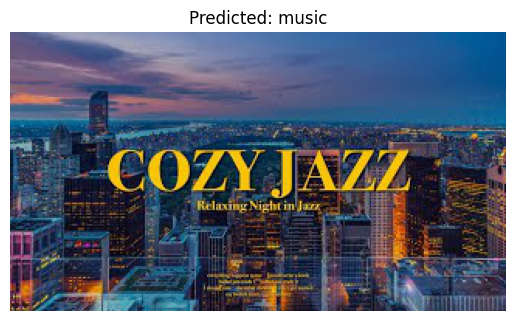

In [27]:
import requests

vid = 'r_E_-FRiyKc'
thumbnail_url = f'https://img.youtube.com/vi/{vid}/mqdefault.jpg'
response = requests.get(thumbnail_url)
with open(f'{vid}.jpg', 'wb') as f:
  f.write(response.content)
predict_image(vit_classifier, f'{vid}.jpg', selected_category)

## If category is four?

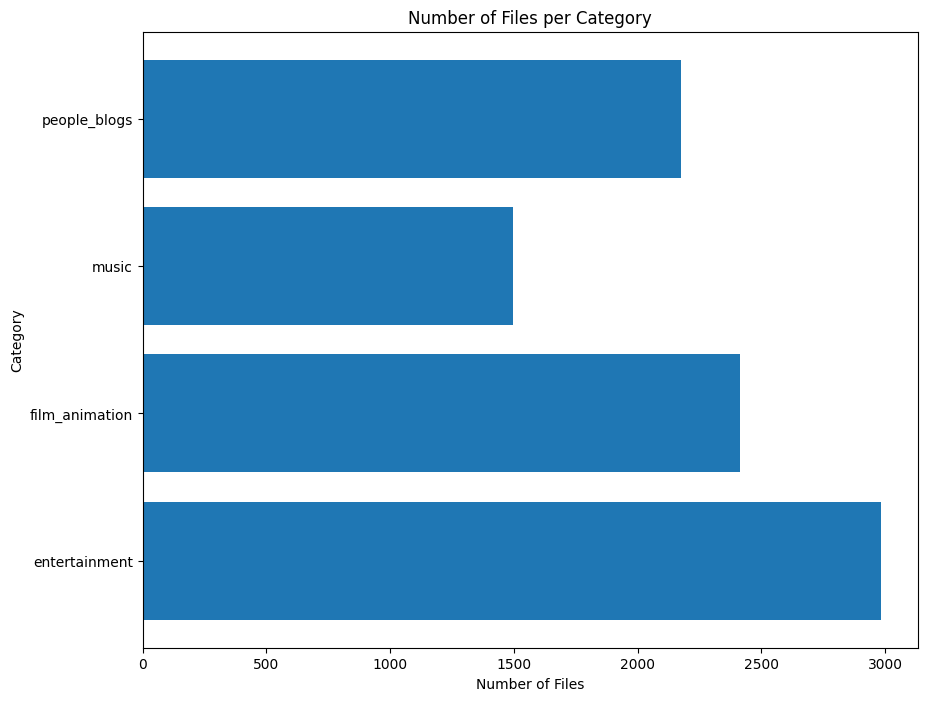

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

category_df = pd.read_csv('video_category.csv')
category_info = category_df.set_index('name')['id'].to_dict()


selected_category = [
    'entertainment', 'film_animation', 
    'music', 'people_blogs'
]

num_classes = len(selected_category)

category_counts = {}
total_counts = 0

for c in selected_category:
  dir = os.path.join(data_path, c)
  category_counts[c] = len(os.listdir(dir))
  total_counts += category_counts[c]

plt.figure(figsize=(10, 8))
plt.barh(list(category_counts.keys()), list(category_counts.values()))
plt.xlabel('Number of Files')
plt.ylabel('Category')
plt.title('Number of Files per Category')
plt.show()

In [41]:
import numpy as np

category_index = {v:k for k,v in category_info.items()}
ctoi = [-1] * 30
now = 0
for i in sorted(list(category_index.keys())):
  if category_index[i] in selected_category:
    ctoi[i] = now
    now = now + 1

In [42]:
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


flat_data_arr=[] #input array
target_arr=[] #output array

x=[]
y=np.array([])

#path which contains all the categories of images
for c in selected_category:
    print(f'loading... category : {c}')
    path = os.path.join(data_path, c)
    size = 0
    for img in os.listdir(path):
      i = imread(os.path.join(path,img))
      if i.shape == (180, 320, 3):
        x += [i]
        size += 1
    y = np.append(y, np.array([ctoi[category_info[c]]] * size))
    print(f'loaded category:{c} successfully')

loading... category : entertainment
loaded category:entertainment successfully
loading... category : film_animation
loaded category:film_animation successfully
loading... category : music
loaded category:music successfully
loading... category : people_blogs
loaded category:people_blogs successfully


In [43]:
# flat_data=np.array(flat_data_arr)
x=np.stack(x)
y=y.reshape(-1,1)
# flat_data *= 255

In [44]:
x.shape

(9070, 180, 320, 3)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.7, random_state=12245
)

In [46]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [47]:
class_weight = {}
for idx, category_idx in enumerate(ctoi):
  if category_idx != -1:
    class_weight[category_idx] = (1 / category_counts[category_index[idx]]) * (total_counts / 2.0)
print(class_weight)

{0: 1.8778467908902692, 1: 3.031417112299465, 2: 2.0831419384474046, 3: 1.5207914151576123}


In [48]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
        class_weight=class_weight
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier_reduced = create_vit_classifier()
history_reduced = run_experiment(vit_classifier_reduced)

Epoch 1/100
23/23 [==============================] - 17s 287ms/step - loss: 6.1957 - accuracy: 0.3033 - val_loss: 1.3678 - val_accuracy: 0.3543
Epoch 2/100
23/23 [==============================] - 6s 244ms/step - loss: 3.1918 - accuracy: 0.3217 - val_loss: 1.2572 - val_accuracy: 0.4409
Epoch 3/100
23/23 [==============================] - 3s 150ms/step - loss: 2.9021 - accuracy: 0.3514 - val_loss: 1.2925 - val_accuracy: 0.3921
Epoch 4/100
23/23 [==============================] - 3s 148ms/step - loss: 2.7060 - accuracy: 0.3820 - val_loss: 1.2581 - val_accuracy: 0.4299
Epoch 5/100
23/23 [==============================] - 4s 197ms/step - loss: 2.6183 - accuracy: 0.3992 - val_loss: 1.2423 - val_accuracy: 0.4457
Epoch 6/100
23/23 [==============================] - 5s 233ms/step - loss: 2.5394 - accuracy: 0.4197 - val_loss: 1.2322 - val_accuracy: 0.4535
Epoch 7/100
23/23 [==============================] - 5s 198ms/step - loss: 2.4675 - accuracy: 0.4410 - val_loss: 1.2089 - val_accuracy: 0.458

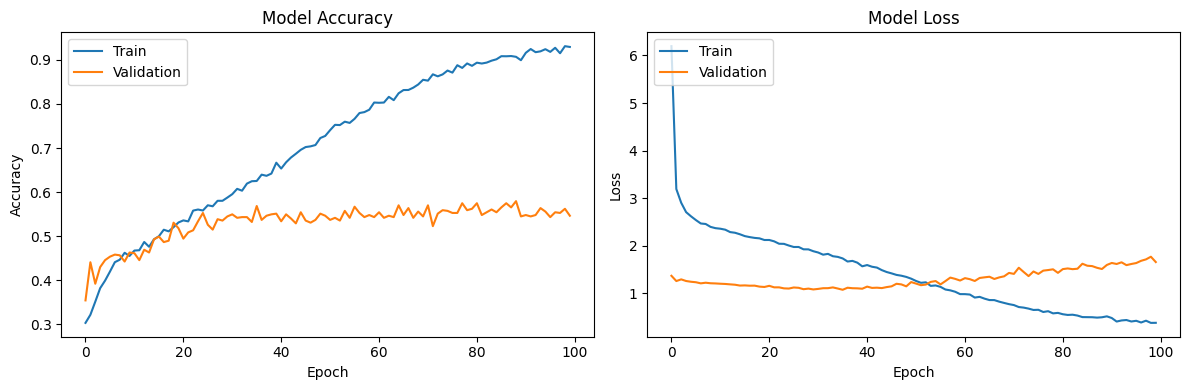

In [49]:
# 학습 과정 시각화
plot_training_history(history_reduced)

In [50]:
vit_classifier_reduced.save('/content/drive/MyDrive/yt-classifier/vit_model_reduced.h5')

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import joblib


load_model = keras.models.load_model(
    '/content/drive/MyDrive/yt-classifier/vit_model.h5',
    custom_objects={
        'Patches': Patches,
        'PatchEncoder': PatchEncoder
    }
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 예측 결과 시각화 및 분석
def predict_image(model, image_path, class_names):
    img_path = image_path
    img = imread(img_path)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    print(prediction)
    predicted_label = np.argmax(prediction)
    print(predicted_label)
    confidence = prediction[0][predicted_label]

    plt.imshow(img)
    plt.axis('off') # 
    plt.title(f"Predicted: {class_names[predicted_label]}")
    plt.show()

In [ ]:
# 이미지 예측
image_path = '/content/thumbnail/gaming/6Q199tLsOXM.jpg'
predict_image(load_model, image_path, selected_category)

1/1 [==============================] - 0s 33ms/step
[[-1.5991206 -2.06086    2.5812237  1.456667 ]]
2


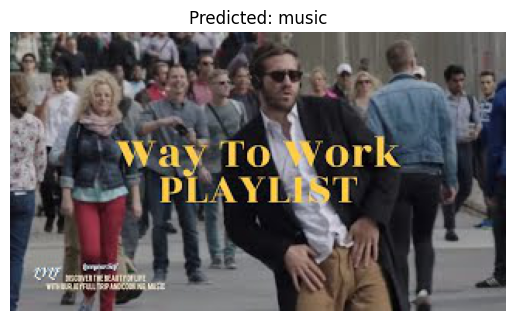

In [54]:
import requests

vid = 'TqOhl8lhpGk'
thumbnail_url = f'https://img.youtube.com/vi/{vid}/mqdefault.jpg'
response = requests.get(thumbnail_url)
with open(f'{vid}.jpg', 'wb') as f:
  f.write(response.content)
predict_image(vit_classifier_reduced, f'{vid}.jpg', selected_category)